In [16]:
import numpy as np
#from plotly.offline import iplot
#import plotly.graph_objs as go
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.manual_seed(42)

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=5, depth=1):
        """
        Initializes all required hyperparameters for a typical model and dynamically
        creates layers based on the depth of the network.

        Args:
            input_features (int): Number of input features to the model.
            output_features (int): Number of output features of the model (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 5.
            depth (int): Determines the depth of the network, default 3.
        """
        super().__init__()
        
        layers = [nn.Linear(in_features=input_features, out_features=hidden_units), nn.Sigmoid()]
        
        # Add hidden layers based on the depth parameter
        for _ in range(depth - 1):
            layers.append(nn.Linear(in_features=hidden_units, out_features=hidden_units))
            layers.append(nn.Sigmoid())
        
        # Add the final layer
        layers.append(nn.Linear(in_features=hidden_units, out_features=output_features))
        
        # Create the sequential model
        self.stack = nn.Sequential(*layers)

    def forward(self, x):
        return self.stack(x)

In [18]:
# Custom loss function constructor
# gamma controls the weighting of the BC loss terms
class CustomLoss(nn.Module):
    def __init__(self, gamma=1): # gamma default value in use
        super(CustomLoss, self).__init__()
        self.gamma = gamma

    # WORTH THINKING ABOUT ADJUSTING THIS TO WORK WITH DERIVATIVE CONDITIONS AT THE DOMAIN'S EXTREMES
        
    # this is 
    def forward(self, x, y, y_a, y_b, g):
        y_x = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
        y_xx = torch.autograd.grad(y_x, x, torch.ones_like(y_x), create_graph=True)[0]
        custom_loss = (torch.mean((-y_xx + y**2 - g(x))**2) +
                       self.gamma * (y[0] - y_a) ** 2 + self.gamma * (y[-1] - y_b) ** 2)
        return custom_loss

In [19]:
def train_model(model, optimiser, loss_class,
                domain_ends, bcs, g_func, x_train, no_epochs):
    for epoch in range(no_epochs):
        # TRAINING
        model.train()

        # 1. Forward pass: The my_model goes through all the training data once
        y_pred = model(x_train)
        # y_pred = y_pred + (b-x_train)/(b-a)*(y_a-y_pred[0]) + (x_train-a)/(b-a)*(y_b-y_pred[-1])
        y_pred.requires_grad_(True)

        # 2. Calculate loss and accuracy: The my_model's predictions are compared to the true values
        loss = loss_class(x_train, y_pred, bcs[0], bcs[1], g_func)
        
        # 3. Optimizer zero grad: The optimizers gradients are set to zero (they are accumulated by default)
        optimiser.zero_grad()

        # 4. Backpropagation: Computes the gradient of the loss with respect for every my_model parameter to be updated
        loss.backward()

        # 5. Optimizer step: Update the parameters
        optimiser.step()

        # Print out what's happening
        if epoch % 500 == 0:
            print(f"Epoch: {epoch} | Loss: {loss.item():e}")

In [20]:
# EXACT SOLUTION

def exact_sol(x):
    return 1 + x * (1 - x)

In [27]:
"""

ENTERING RELEVANT PARAMETERS

"""

# BOUNDARY VALUE PROBLEM
# ODE: -y'' + y^2 = g(x)
# y(0) = y(1) = 1
domain_ends = (0,1)
bcs = (1,1) # DIRICHLET

# easily verify the following exact solution
def g_func(x): return 3 + 2 * x - x**2 - 2 * x**3 + x**4


# MODEL
ANN_width = 5
ANN_depth = 1


# TRAINING
no_epochs = 7000
learning_rate = 0.08


training_points = np.linspace(domain_ends[0], domain_ends[1], 100)
x_train = torch.tensor(training_points).resize_(len(training_points), 1)
x_train = x_train.to(torch.float32).requires_grad_(True)

# LOSS
loss_class = CustomLoss(gamma=5)

In [28]:
# TRAIN THE MODEL, RESET IT EACH RUN
model = NeuralNetwork(1, 1, ANN_width, ANN_depth)
optimiser = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

train_model(model, optimiser, loss_class, domain_ends, bcs, g_func, x_train, no_epochs)

Epoch: 0 | Loss: 1.166007e+01
Epoch: 500 | Loss: 4.330182e-03
Epoch: 1000 | Loss: 2.530953e-03
Epoch: 1500 | Loss: 1.676546e-03
Epoch: 2000 | Loss: 1.191835e-03
Epoch: 2500 | Loss: 1.490954e-03
Epoch: 3000 | Loss: 6.495447e-04
Epoch: 3500 | Loss: 4.207811e-04
Epoch: 4000 | Loss: 1.767458e-04
Epoch: 4500 | Loss: 6.451812e-04
Epoch: 5000 | Loss: 1.363102e-05
Epoch: 5500 | Loss: 8.287494e-06
Epoch: 6000 | Loss: 9.061753e-05
Epoch: 6500 | Loss: 9.659199e-03


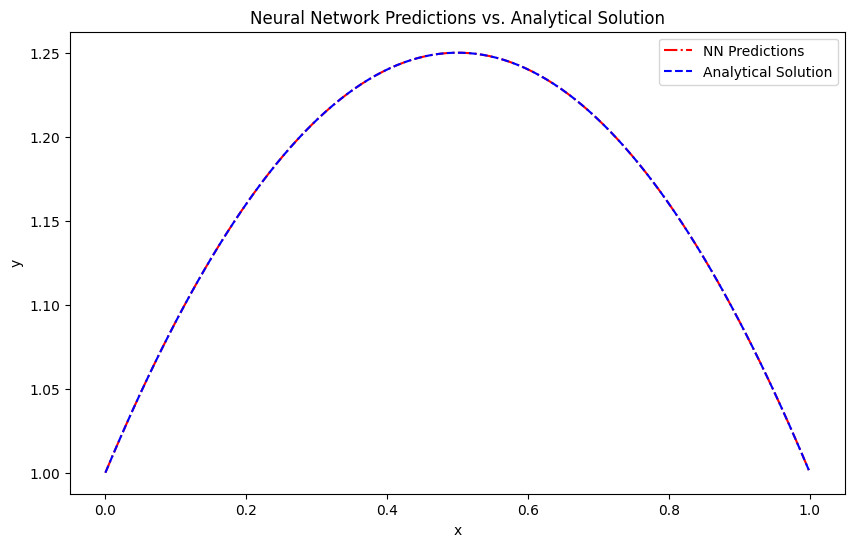

In [29]:
def plot_predictions_vs_analytical(model, x_train_tensor, exact_solution_func):
    # Convert the training tensor to numpy for plotting
    x_train_numpy = x_train_tensor.detach().numpy().flatten()
    
    # Predictions from the neural network
    with torch.no_grad():  # We do not need gradients for plotting
        y_pred_tensor = model(x_train_tensor)
    y_pred_numpy = y_pred_tensor.detach().numpy().flatten()
    
    # Analytical solution
    y_exact_numpy = exact_solution_func(x_train_numpy)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_train_numpy, y_pred_numpy, label='NN Predictions', color='r', linestyle='-.')
    plt.plot(x_train_numpy, y_exact_numpy, label='Analytical Solution', color='b', linestyle='--')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Neural Network Predictions vs. Analytical Solution')
    plt.legend()
    plt.show()

# Assuming x_train is already defined and converted to the required format
plot_predictions_vs_analytical(model, x_train, exact_sol)
